In [1]:
from api import *
from collections import defaultdict
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
clean_birmingham_report_df = pd.read_feather('image_time_traffic_reports/clean_birmingham_report_df')
clean_manc_report_df = pd.read_feather('image_time_traffic_reports/clean_manc_report_df')
clean_cam_report_df = pd.read_feather('image_time_traffic_reports/clean_cam_report_df')
clean_thorpe_report_df = pd.read_feather('image_time_traffic_reports/clean_thorpe_report_df')
clean_epping_report_df = pd.read_feather('image_time_traffic_reports/clean_epping_report_df')
clean_bristol_df = pd.read_feather('image_time_traffic_reports/clean_bristol_df')
clean_train_report_df = pd.concat([clean_birmingham_report_df, clean_manc_report_df, clean_cam_report_df, clean_thorpe_report_df, clean_epping_report_df, clean_bristol_df]).reset_index(drop = True)
del clean_birmingham_report_df, clean_manc_report_df, clean_cam_report_df, clean_thorpe_report_df, clean_epping_report_df, clean_bristol_df

In [3]:
# Import these reports
def traffic_count_pipeline(road_lengths, pickle_folder, single_lane = True, guess_speed = False):

    clean_birmingham_report_df = pd.read_feather('image_time_traffic_reports/clean_birmingham_report_df')
    clean_manc_report_df = pd.read_feather('image_time_traffic_reports/clean_manc_report_df')
    clean_cam_report_df = pd.read_feather('image_time_traffic_reports/clean_cam_report_df')
    clean_thorpe_report_df = pd.read_feather('image_time_traffic_reports/clean_thorpe_report_df')
    clean_epping_report_df = pd.read_feather('image_time_traffic_reports/clean_epping_report_df')
    clean_bristol_df = pd.read_feather('image_time_traffic_reports/clean_bristol_df')

    import copy
    traffc_data_england = copy.copy(road_lengths)
    # Combine the traffic reports together
    clean_train_report_df = pd.concat([clean_birmingham_report_df, clean_manc_report_df, clean_cam_report_df, clean_thorpe_report_df, clean_epping_report_df, clean_bristol_df]).reset_index(drop = True)


    sites = []
    for x in list(traffc_data_england.sites):
        sites = sites + x.split(', ')

    # Filter down onto those sites and columns we want
    clean_cols = ['site_name','site_id','report_date','time_period_ending','time_interval',
                  '0-520cm','521-660cm','661-1160cm','1160+cm','avg_mph','total_volume','timestamp']
    filtered_train_report = clean_train_report_df[clean_cols][clean_train_report_df.site_id.isin(sites)]
    
    if guess_speed:
        filtered_train_report.loc[:,'avg_mph'] = '56'

    # For a particular row x in traffc_data_england get the correspoiding traffic data
    def area_report(x):
        sites = x.sites.split(', ')
        day, month, year = x.ddmmyy.split('/')
        hour, minute  = x.time.split(':')

        # Get the nearest of the 15 minute intervals to compare to
        min_mod_15 = round((int(minute)+1)/15)
        nearest_minute_interval = 15*min_mod_15 - 1
        time = datetime.datetime(int(year),int(month),int(day), int(hour), int(nearest_minute_interval))
        x_report = filtered_train_report[(filtered_train_report.site_id.isin(sites)) & (filtered_train_report.timestamp == time)]
        return x_report

    # Add the reports to the dataframe
    traffc_data_england['report'] = traffc_data_england.apply(area_report, axis=1)
    # Extract values from the report
    if single_lane:
        # We take the mean because the traffic sites for each segment are in series
        traffc_data_england['0-520cm'] = traffc_data_england.apply(lambda x: x.report['0-520cm'].mean(), axis=1)
        traffc_data_england['521-660cm'] = traffc_data_england.apply(lambda x: x.report['521-660cm'].mean(), axis=1)
        traffc_data_england['661-1160cm'] = traffc_data_england.apply(lambda x: x.report['661-1160cm'].mean(), axis=1)
        traffc_data_england['1160+cm'] = traffc_data_england.apply(lambda x: x.report['1160+cm'].mean(), axis=1)
        traffc_data_england['total_volume'] = traffc_data_england.apply(lambda x: x.report['total_volume'].mean(), axis=1)
        traffc_data_england['avg_mph'] = traffc_data_england.apply(lambda x: x.report.avg_mph.astype(int).mean(), axis=1)
    else:
        traffc_data_england['0-520cm'] = traffc_data_england.apply(lambda x: x.report['0-520cm'].sum(), axis=1)
        traffc_data_england['521-660cm'] = traffc_data_england.apply(lambda x: x.report['521-660cm'].sum(), axis=1)
        traffc_data_england['661-1160cm'] = traffc_data_england.apply(lambda x: x.report['661-1160cm'].sum(), axis=1)
        traffc_data_england['1160+cm'] = traffc_data_england.apply(lambda x: x.report['1160+cm'].sum(), axis=1)
        traffc_data_england['total_volume'] = traffc_data_england.apply(lambda x: x.report['total_volume'].sum(), axis=1)
        traffc_data_england['avg_mph'] = traffc_data_england.apply(lambda x: x.report.avg_mph.astype(int).mean(), axis=1)

    def predict_traffic_from_detector(data, threshold, pickle_folder):

        traffic_data = copy.copy(data)
        # Initially set the column names so they agree with the names in the pickle files
        detections = pd.DataFrame(
           {
               "filename": [],
               "small_car_detections": [],
               "bus_detections": [],
               "pickup_truck_detections": [],
               "utility_truck_detections": [],
               "truck_detections": [],
               "cargo_truck_detections": [],
               "truck_w_box_detections": [],
               "truck_tractor_detections": [],
               "trailer_detections": [],
               "truck_w_flatbed_detections": [],
               "truck_w_liquid_detections": [],
               "all_vehicle_detections": [],

           }
        )

        # Import the predictions the pickle files
        prediction_lists = defaultdict()

        for i, file in enumerate(os.listdir(pickle_folder)):
            with (open(os.path.join(pickle_folder, file), "rb")) as f:
                prediction_list = pickle.load(f)
            filename = file.split('.')[0]
            prediction_lists[filename] = prediction_list
            counts = defaultdict(int)
            for pred in prediction_list:
                if pred.score.value > threshold:
                    counts[pred.category.name] +=1

            detections.loc[i] = [filename, 
                         counts["Small Car"],
                         counts["Bus"],
                         counts["Pickup Truck"],
                         counts["Utility Truck"],
                         counts["Truck"],
                         counts["Cargo Truck"],
                         counts["Truck w/Box"],
                         counts["Truck Tractor"],
                         counts["Trailer"],
                         counts["Truck w/Flatbed"],
                         counts["Truck w/Liquid"],
                         sum([x for x in counts.values()])]

        # combine the reports    
        def detection_report(x):
            detections_report = detections[detections.filename == x.filename]
            return detections_report

        traffic_data['det_report'] = traffic_data.apply(detection_report, axis=1)

        # get the detection numbers
        traffic_data['small_car_detections'] = traffic_data.apply(lambda x: x.det_report.small_car_detections.sum(), axis=1)
        traffic_data['bus_detections'] = traffic_data.apply(lambda x: x.det_report.bus_detections.sum(), axis=1)
        traffic_data['pickup_truck_detections'] = traffic_data.apply(lambda x: x.det_report.pickup_truck_detections.sum(), axis=1)
        traffic_data['utility_truck_detections'] = traffic_data.apply(lambda x: x.det_report.utility_truck_detections.sum(), axis=1)
        traffic_data['truck_detections'] = traffic_data.apply(lambda x: x.det_report.truck_detections.sum(), axis=1)
        traffic_data['cargo_truck_detections'] = traffic_data.apply(lambda x: x.det_report.cargo_truck_detections.sum(), axis=1)
        traffic_data['truck_w_box_detections'] = traffic_data.apply(lambda x: x.det_report.truck_w_box_detections.sum(), axis=1)
        traffic_data['truck_tractor_detections'] = traffic_data.apply(lambda x: x.det_report.truck_tractor_detections.sum(), axis=1)
        traffic_data['trailer_detections'] = traffic_data.apply(lambda x: x.det_report.trailer_detections.sum(), axis=1)
        traffic_data['truck_w_flatbed_detections'] = traffic_data.apply(lambda x: x.det_report.truck_w_flatbed_detections.sum(), axis=1)
        traffic_data['truck_w_liquid_detections'] = traffic_data.apply(lambda x: x.det_report.truck_w_liquid_detections.sum(), axis=1)
        traffic_data['all_vehicle_detections'] = traffic_data.apply(lambda x: x.det_report.all_vehicle_detections.sum(), axis=1)

        # Predict the traffic count from these detections via raodlength and avg speed
        traffic_data['length_milles'] = traffic_data.length.apply(lambda x: x/1000 *5/8)
        if single_lane:
            # If we are looking at single lanes then the length is correct
            traffic_data['time_to_cross_hour'] = traffic_data.apply(lambda x : x.length_milles/x.avg_mph , axis=1)
        else:
            # If we are looking at double lanes we need to hald the length to get the average length.
            traffic_data['time_to_cross_hour'] = traffic_data.apply(lambda x : x.length_milles/x.avg_mph * 1/2 , axis=1)
        
        traffic_data['time_to_cross_min'] = traffic_data.apply(lambda x : x.time_to_cross_hour * 60 , axis=1)

        detection_cols = ['small_car_detections',
         'bus_detections',
         'pickup_truck_detections',
         'utility_truck_detections',
         'truck_detections',
         'cargo_truck_detections',
         'truck_w_box_detections',
         'truck_tractor_detections',
         'trailer_detections',
         'truck_w_flatbed_detections',
         'truck_w_liquid_detections',
         'all_vehicle_detections']

        for col in detection_cols:
            pred_col = col.replace('detections', 'pred')
            traffic_data[pred_col] = traffic_data[col] * 15 / traffic_data['time_to_cross_min']

        return traffic_data
    
    traffic_data_yolov5 = predict_traffic_from_detector(traffc_data_england, 0.15, pickle_folder)
    return traffic_data_yolov5

In [4]:
def plot_relative_error(plot_data):
    plot_data['percent_error'] = (plot_data.all_vehicle_pred.values - plot_data.total_volume.values) / plot_data.total_volume.values

    fig, ax = plt.subplots()
    
    graph = sns.barplot(x="filename", y="percent_error", hue="area", data=plot_data, ax=ax, palette = palette, hue_order = unique)
    ax.axhline(plot_data.percent_error.mean(), color='black', alpha=0.5)
    ax.axhline(0, color='black', alpha = 0.8)    
    lgd = ax.legend(bbox_to_anchor= (1,1))
    ax.text(39.8, plot_data.percent_error.mean(), f'Mean Relative Error = {int(100*plot_data.percent_error.mean())}%', va='center')

    plt.ylabel('Percentage error in Traffic Count Prediction')
    plt.xlabel('Image')

    labels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticks([])


    # taken from https://stackoverflow.com/questions/34888058/changing-width-of-bars-in-bar-chart-created-using-seaborn-factorplot 
    def change_width(ax, new_value) :
        for patch in ax.patches :
            current_width = patch.get_width()
            diff = current_width - new_value

            # we change the bar width
            patch.set_width(new_value)

            # we recenter the bar
            patch.set_x(patch.get_x() + diff * .5)

    change_width(ax, .35)

    plt.savefig('relative_errors-single-lane', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)
    plt.show()

    print(f"max rel error {plot_data.percent_error.max()}, \nmin rel error {plot_data.percent_error.min()}")

In [5]:
def plot_error(plot_data):
    plot_data['error'] = plot_data.all_vehicle_pred.values - plot_data.total_volume.values

    fig, ax = plt.subplots()

    graph = sns.barplot(x="filename", y="error", hue="area", data=plot_data, ax=ax, palette = palette, hue_order = unique)
    ax.axhline(plot_data.error.mean(), color='black', alpha=0.5)
    ax.axhline(0, color='black', alpha = 0.8)    
    lgd = ax.legend(bbox_to_anchor= (1,1))
    ax.text(39.8, plot_data.error.mean(), f'Mean  Error = {int(plot_data.error.mean())}', va='center')

    plt.ylabel('Error in Traffic Count Prediction')
    plt.xlabel('Image')

    labels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticks([])


    # taken from https://stackoverflow.com/questions/34888058/changing-width-of-bars-in-bar-chart-created-using-seaborn-factorplot 
    def change_width(ax, new_value) :
        for patch in ax.patches :
            current_width = patch.get_width()
            diff = current_width - new_value

            # we change the bar width
            patch.set_width(new_value)

            # we recenter the bar
            patch.set_x(patch.get_x() + diff * .5)

    change_width(ax, .35)

    plt.savefig('relative_errors-single-lane', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)
    plt.show()

    print(f"max error {plot_data.error.max()}, \nmin error {plot_data.error.min()}")

In [6]:
def plot_actual_vs_predicted(plot_data):
    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(x='all_vehicle_pred', y='total_volume', hue='area', data=plot_data, ax=ax, palette = palette)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    plt.plot(lims, lims, 'k-', alpha=0.5)

    plt.show()

    mse = ((plot_data.total_volume.values - plot_data.all_vehicle_pred.values)**2).sum()/len(plot_data)
    mape = np.absolute(((plot_data.total_volume.values - plot_data.all_vehicle_pred.values) / plot_data.total_volume.values)).mean()

    print(f"rmse {mse**0.5}, mape. {mape}")

## Single Lane Inference

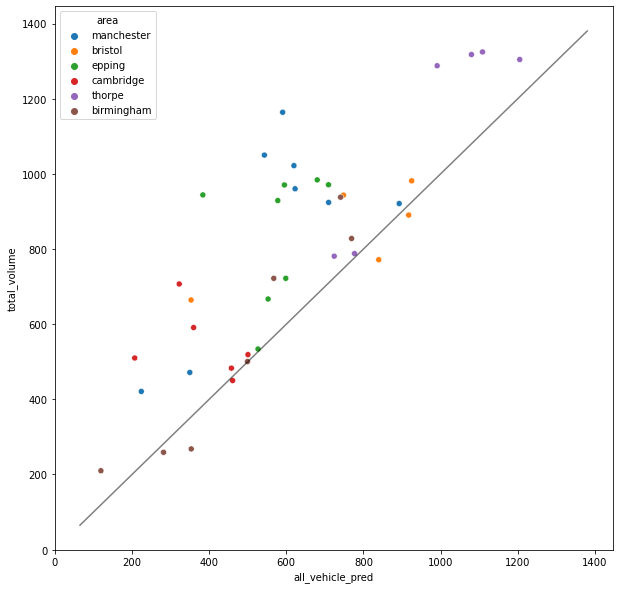

rmse 247.66000590639155, mape. 0.23918467316452457


In [7]:
road_lengths = pd.read_csv('road_lengths_single_lane-fixed-time.csv') 
pickle_folder = '../inference/results/single-lane-yolov5/pickles'

traffic_data_yolov5_single_lane = traffic_count_pipeline(road_lengths, pickle_folder, single_lane = True)
traffic_data_yolov5_single_lane = traffic_data_yolov5_single_lane[traffic_data_yolov5_single_lane.length > 900]
traffic_data_yolov5_single_lane = traffic_data_yolov5_single_lane[traffic_data_yolov5_single_lane.filename != 'epping_MS5_W_3'].reset_index(drop=True)
traffic_data_yolov5_single_lane['error'] = traffic_data_yolov5_single_lane.all_vehicle_pred.values - traffic_data_yolov5_single_lane.total_volume.values
traffic_data_yolov5_single_lane['percent_error'] = (traffic_data_yolov5_single_lane.all_vehicle_pred.values - traffic_data_yolov5_single_lane.total_volume.values) / traffic_data_yolov5_single_lane.total_volume.values

unique = traffic_data_yolov5_single_lane["area"].unique()
palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))

plot_actual_vs_predicted(traffic_data_yolov5_single_lane)

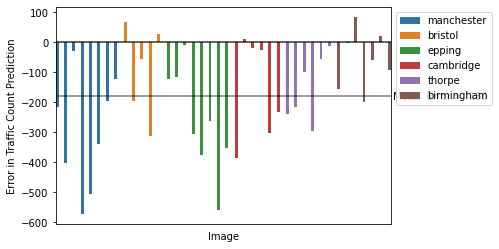

max error 85.52964203383937, 
min error -573.4995734991053


In [8]:
plot_error(traffic_data_yolov5_single_lane)

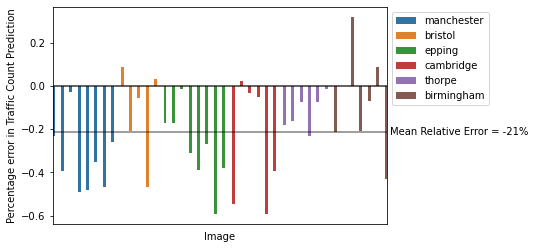

max rel error 0.3191404553501469, 
min rel error -0.5941007345894315


In [9]:
plot_relative_error(traffic_data_yolov5_single_lane)

### Bad Speed Data

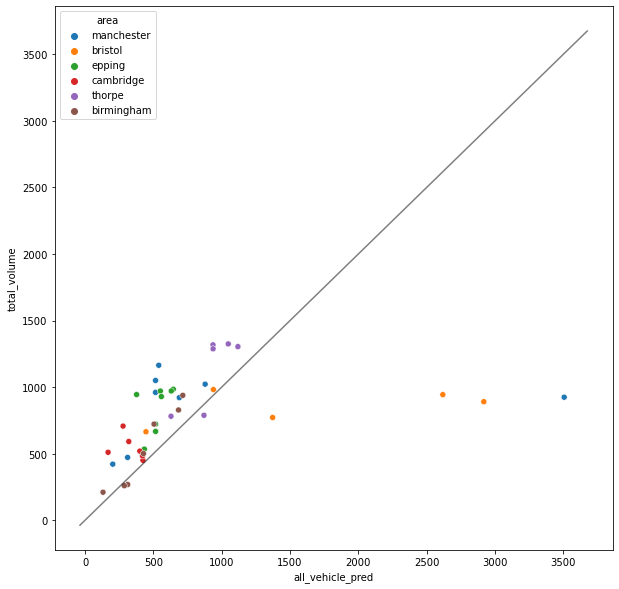

rmse 650.07007131894, mape. 0.4615911767396318


In [10]:
traffic_data_yolov5_single_lane_bad_speed = traffic_count_pipeline(road_lengths, pickle_folder, single_lane = True, guess_speed= True)
traffic_data_yolov5_single_lane_bad_speed = traffic_data_yolov5_single_lane_bad_speed[traffic_data_yolov5_single_lane_bad_speed.length > 900]
traffic_data_yolov5_single_lane_bad_speed = traffic_data_yolov5_single_lane_bad_speed[traffic_data_yolov5_single_lane_bad_speed.filename != 'epping_MS5_W_3'].reset_index(drop=True)
traffic_data_yolov5_single_lane_bad_speed['error'] = traffic_data_yolov5_single_lane_bad_speed.all_vehicle_pred.values - traffic_data_yolov5_single_lane_bad_speed.total_volume.values
traffic_data_yolov5_single_lane_bad_speed['percent_error'] = (traffic_data_yolov5_single_lane_bad_speed.all_vehicle_pred.values - traffic_data_yolov5_single_lane_bad_speed.total_volume.values) / traffic_data_yolov5_single_lane_bad_speed.total_volume.values

plot_actual_vs_predicted(traffic_data_yolov5_single_lane_bad_speed)

## Double Lane Inference

In [11]:
road_lengths = pd.read_csv('road_lengths-fixed-time.csv') 
pickle_folder = '../inference/results/double-lane-yolov5/pickles'

traffic_data_yolov5_double_lane = traffic_count_pipeline(road_lengths, pickle_folder, single_lane = False)
traffic_data_yolov5_double_lane['error'] = traffic_data_yolov5_double_lane.all_vehicle_pred.values - traffic_data_yolov5_double_lane.total_volume.values
traffic_data_yolov5_double_lane['percent_error'] = (traffic_data_yolov5_double_lane.all_vehicle_pred.values - traffic_data_yolov5_double_lane.total_volume.values) / traffic_data_yolov5_double_lane.total_volume.values

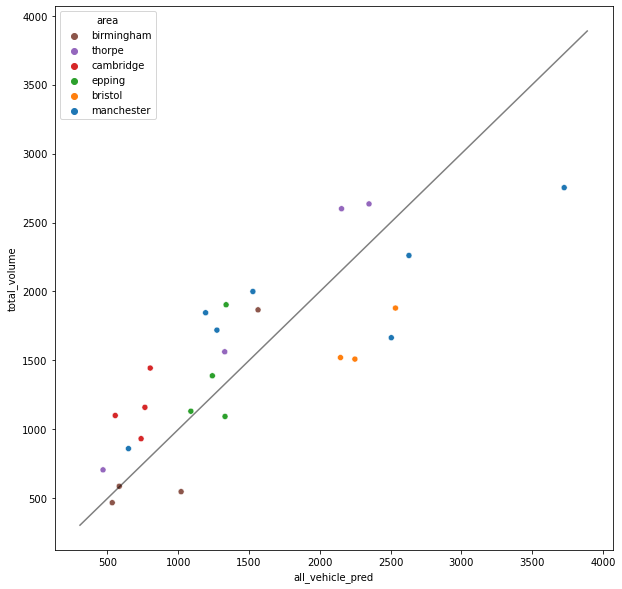

rmse 482.88086298978124, mape. 0.28649401462153073


In [12]:
plot_actual_vs_predicted(traffic_data_yolov5_double_lane)

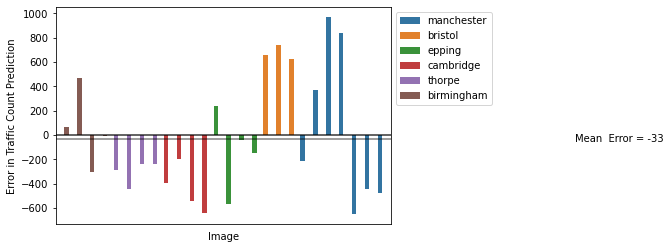

max error 972.5851201006235, 
min error -652.8953076065452


In [13]:
plot_error(traffic_data_yolov5_double_lane)

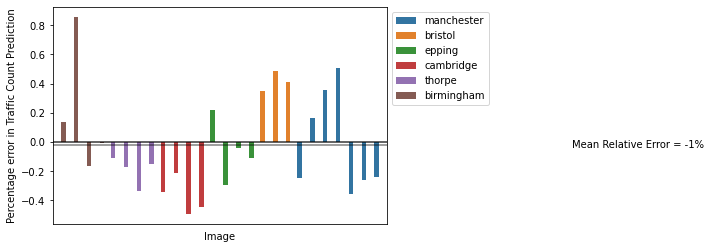

max rel error 0.8581893186552397, 
min rel error -0.4960358757006615


In [14]:
plot_relative_error(traffic_data_yolov5_double_lane)

### Bad Speed Data

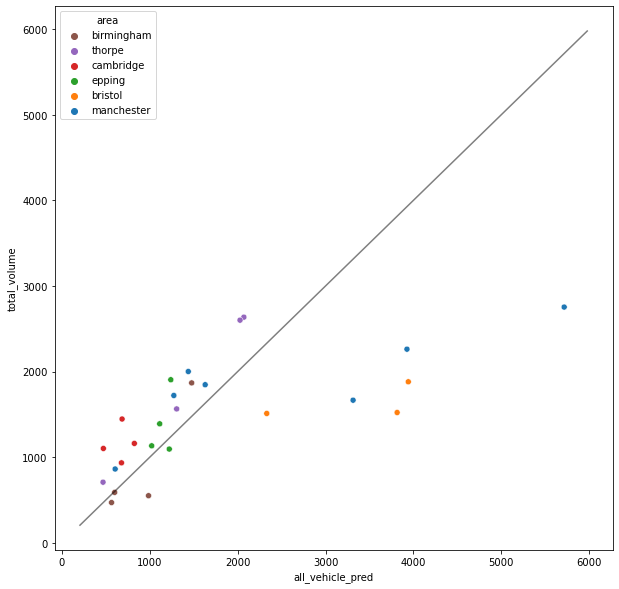

rmse 1036.1042604462239, mape. 0.44226869629072674


In [15]:
traffic_data_yolov5_double_lane_bad_speed = traffic_count_pipeline(road_lengths, pickle_folder, single_lane = False, guess_speed = True)
traffic_data_yolov5_double_lane_bad_speed['error'] = traffic_data_yolov5_double_lane_bad_speed.all_vehicle_pred.values - traffic_data_yolov5_double_lane_bad_speed.total_volume.values
traffic_data_yolov5_double_lane_bad_speed['percent_error'] = (traffic_data_yolov5_double_lane_bad_speed.all_vehicle_pred.values - traffic_data_yolov5_double_lane_bad_speed.total_volume.values) / traffic_data_yolov5_double_lane_bad_speed.total_volume.values
plot_actual_vs_predicted(traffic_data_yolov5_double_lane_bad_speed)

# Error Analysis

### Inspect Examples

## Gridlock

In [16]:
traffic_data_yolov5_double_lane[traffic_data_yolov5_double_lane.avg_mph<40][['filename', 'avg_mph','error','percent_error']]

,filename,avg_mph,error,percent_error
16,M4_bristol,36.0,654.029107,0.347888
18,M5_bristol,31.5,624.673438,0.410699
20,M60_1_manchester,37.5,368.261698,0.162876
21,M60_2_manchester,36.5,972.585120,0.353282


In [17]:
traffic_data_yolov5_single_lane[traffic_data_yolov5_single_lane.avg_mph < 40][['filename', 'avg_mph','error','percent_error']]

,filename,avg_mph,error,percent_error
0,manchester_M60_N_1,11.333333,-214.193772,-0.231811
1,manchester_M60_N_4,39.500000,-402.222587,-0.393564
8,bristol_M4_N_1,34.250000,68.172905,0.088364
9,bristol_M4_N_2,16.000000,-195.272351,-0.206966
12,bristol_M5_W_1,17.600000,26.914562,0.030227


## Bristol

### M5

In [18]:
bristol_M5_gridlock = ['bristol_M5_W_1', 'bristol_M5_E_1']
traffic_data_yolov5_single_lane[traffic_data_yolov5_single_lane.filename.isin(bristol_M5_gridlock)][['filename', 'avg_mph','error','percent_error']]

,filename,avg_mph,error,percent_error
11,bristol_M5_E_1,44.4,-311.284984,-0.468520
12,bristol_M5_W_1,17.6,26.914562,0.030227


In [19]:
traffic_data_yolov5_double_lane[traffic_data_yolov5_double_lane.filename == 'M5_bristol'][['filename', 'avg_mph','error','percent_error']]

,filename,avg_mph,error,percent_error
18,M5_bristol,31.5,624.673438,0.410699


### M4

In [20]:
bristol_M4_gridlock = ['bristol_M4_N_2', 'bristol_M4_S_2']
traffic_data_yolov5_single_lane[traffic_data_yolov5_single_lane.filename.isin(bristol_M4_gridlock)][['filename', 'avg_mph','error','percent_error']]

,filename,avg_mph,error,percent_error
9,bristol_M4_N_2,16.000000,-195.272351,-0.206966
10,bristol_M4_S_2,55.166667,-56.485278,-0.057550


In [21]:
traffic_data_yolov5_double_lane[traffic_data_yolov5_double_lane.filename == 'M4_bristol'][['filename', 'avg_mph','error','percent_error']]

,filename,avg_mph,error,percent_error
16,M4_bristol,36.0,654.029107,0.347888
